In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from plotting import add_panel_labels

from deepmip_dict import deepmip_dict

data_dir = '/Users/wb19586/Documents/coding_github/aprp_deepmip/ebm_output_data/'
figure_dir = '/Users/wb19586/Documents/coding_github/aprp_deepmip/figures/'

In [2]:
# define functions
def select_area(da,min_lat,max_lat, lat_name='lat'):
    # Check if the latitude dimension is monotonically increasing or decreasing
    if da[lat_name].values[0] < da[lat_name].values[-1]:
        # Latitude is increasing
        return da.sel(lat=slice(min_lat, max_lat))
    else:
        # Latitude is decreasing
        return da.sel(lat=slice(max_lat, min_lat))


In [3]:
# initialize dictionaries to store global and regional means
GLO_means = {}
NP_means = {}
SP_means = {}
TRO_means = {}
AMP_means = {}

# define variables for regional means
vars_to_process = ['ts1', 'ts2', 'dt_salb', 'dt_aprp_alf', 'dt_swcre', 'dt_aprp_cld', 'dt_aprp_clr', 'dt_palb', 'dt_emm', 'dt_htc', 'dt_swcre', 'dt_lwcre']

# import EBM results
for model in deepmip_dict.keys():
    print(model)
    ncases = deepmip_dict[model]['ncase']

    # Initialize dictionaries for this model
    GLO_means[model] = {}
    NP_means[model] = {}
    SP_means[model] = {}
    TRO_means[model] = {}
    AMP_means[model] = {}

    # create figure
    fig, axs = plt.subplots(ncases, 2, figsize=(14, 5 * ncases))
    for i in range(ncases):

        scenario = f"{deepmip_dict[model]['contr'][i]}_to_{deepmip_dict[model]['sensi'][i]}"
        GLO_means[model][scenario] = {}
        NP_means[model][scenario] = {}
        SP_means[model][scenario] = {}
        TRO_means[model][scenario] = {}
        AMP_means[model][scenario] = {}

        ebm_file = model + '.' + deepmip_dict[model]['contr'][i] +'.to.' + deepmip_dict[model]['sensi'][i] + '.ebm.nc'
        ebm      = xr.open_dataset(data_dir + '/deepmip/' + ebm_file, decode_times=False)
        ebm_ym   = ebm.mean('time')

        # plot total change
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_gcm'], label='temp change (GCM)', linewidth=2, color='black', linestyle='solid')
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_ebm'], label='temp change (EBM)', linewidth=2, alpha=0.5, color='black', linestyle='dashed')

        # plot surface albedo
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_salb'], label='EBM: surface albedo', linewidth=2, color='green', linestyle='solid')
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_aprp_alf'], label='APRP: surface albedo', linewidth=2, color='green', alpha=0.5, linestyle='dashed')

        # plot cloud feedbacks
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_palb']-ebm_ym['dt_salb'], label='EBM: non-surface albedo', linewidth=2, color='blue', linestyle='solid')
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_aprp_cld'], label='APRP: SW clouds', linewidth=2, color='blue', alpha=0.5, linestyle='dashed')

        # plot clear sky feedbacks
        axs[i,0].plot(ebm_ym['lat'], ebm_ym['dt_aprp_clr'], label='APRP: clear sky', linewidth=2, color='orange', alpha=0.5, linestyle='dashed')

        axs[i,1].plot(ebm_ym['lat'], ebm_ym['dt_palb'], label='EBM: plan. albedo', color='black', linestyle='solid', linewidth=2)
        axs[i,1].plot(ebm_ym['lat'], ebm_ym['dt_aprp_alf'] + ebm_ym['dt_aprp_cld'] + ebm_ym['dt_aprp_clr'], label='APRP: alf+cld+clr', color='red', linestyle='dashed', linewidth=2)

        for p in range(2):
            axs[i,p].set_title(f"{model} - {deepmip_dict[model]['contr'][i]} to {deepmip_dict[model]['sensi'][i]}")
            axs[i,p].axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)
            axs[i,p].set_ylim([-20, 40])  
            axs[i,p].legend()

        # calculate global and regional means and save to dictionaries
        for var in vars_to_process:
            ebm_ym_GLO = ebm_ym[var]
            ebm_ym_NP = select_area(ebm_ym[var],60,90)
            ebm_ym_SP = select_area(ebm_ym[var],-90,-60)
            ebm_ym_TRO = select_area(ebm_ym[var],-30,30)

            coslat_GLO = np.cos(np.deg2rad(ebm_ym_GLO.lat))
            coslat_NP = np.cos(np.deg2rad(ebm_ym_NP.lat))
            coslat_SP = np.cos(np.deg2rad(ebm_ym_SP.lat))
            coslat_T = np.cos(np.deg2rad(ebm_ym_TRO.lat))

            GLO_means[model][scenario][var] = ebm_ym_GLO.weighted(coslat_GLO).mean(('lat'))
            NP_means[model][scenario][var] = ebm_ym_NP.weighted(coslat_NP).mean(('lat'))
            SP_means[model][scenario][var] = ebm_ym_SP.weighted(coslat_SP).mean(('lat'))
            TRO_means[model][scenario][var] = ebm_ym_TRO.weighted(coslat_T).mean(('lat'))
            AMP_means[model][scenario][var] = ( NP_means[model][scenario][var] + SP_means[model][scenario][var] ) / 2 - TRO_means[model][scenario][var]


    plt.tight_layout()
    # plt.savefig(f"{model}_plots.pdf")  # Save each model's plots as a PDF
    plt.close()



CESM1.2-CAM5
COSMOS-landveg-r2413
GFDL-CM2.1
HadCM3B-M2.1aN
IPSLCM5A2
MIROC4m
NorESM1-F


In [11]:
# Initialize dictionaries for ensemble means and counts
ensemble_GLO_means = {}
ensemble_NP_means = {}
ensemble_SP_means = {}
ensemble_TRO_means = {}
ensemble_AMP_means = {}

ensemble_model_counts = {}

# Calculate ensemble means
for model in GLO_means.keys():
    for scenario in GLO_means[model].keys():
        if scenario not in ensemble_GLO_means:
            ensemble_GLO_means[scenario] = {var: 0 for var in vars_to_process}
            ensemble_NP_means[scenario] = {var: 0 for var in vars_to_process}
            ensemble_SP_means[scenario] = {var: 0 for var in vars_to_process}
            ensemble_TRO_means[scenario] = {var: 0 for var in vars_to_process}
            ensemble_AMP_means[scenario] = {var: 0 for var in vars_to_process}
            ensemble_model_counts[scenario] = 0

        ensemble_model_counts[scenario] += 1

        for var in vars_to_process:
            ensemble_GLO_means[scenario][var] += GLO_means[model][scenario][var]
            ensemble_NP_means[scenario][var] += NP_means[model][scenario][var]
            ensemble_SP_means[scenario][var] += SP_means[model][scenario][var]
            ensemble_TRO_means[scenario][var] += TRO_means[model][scenario][var]
            ensemble_AMP_means[scenario][var] += AMP_means[model][scenario][var]

# Divide by the number of models to get the mean
for scenario in ensemble_GLO_means.keys():
    n_models = ensemble_model_counts[scenario]
    for var in vars_to_process:
        ensemble_GLO_means[scenario][var] /= n_models
        ensemble_NP_means[scenario][var] /= n_models
        ensemble_SP_means[scenario][var] /= n_models
        ensemble_TRO_means[scenario][var] /= n_models
        ensemble_AMP_means[scenario][var] /= n_models

# Save ensemble means using 'ensemble-mean' as the model name
ensemble_model = 'ensemble-mean'
GLO_means[ensemble_model] = {}
NP_means[ensemble_model] = {}
SP_means[ensemble_model] = {}
TRO_means[ensemble_model] = {}
AMP_means[ensemble_model] = {}

for scenario in ensemble_GLO_means.keys():
    GLO_means[ensemble_model][scenario] = {}
    NP_means[ensemble_model][scenario] = {}
    SP_means[ensemble_model][scenario] = {}
    TRO_means[ensemble_model][scenario] = {}
    AMP_means[ensemble_model][scenario] = {}

    for var in vars_to_process:
        GLO_means[ensemble_model][scenario][var] = ensemble_GLO_means[scenario][var]
        NP_means[ensemble_model][scenario][var] = ensemble_NP_means[scenario][var]
        SP_means[ensemble_model][scenario][var] = ensemble_SP_means[scenario][var]
        TRO_means[ensemble_model][scenario][var] = ensemble_TRO_means[scenario][var]
        AMP_means[ensemble_model][scenario][var] = ensemble_AMP_means[scenario][var]

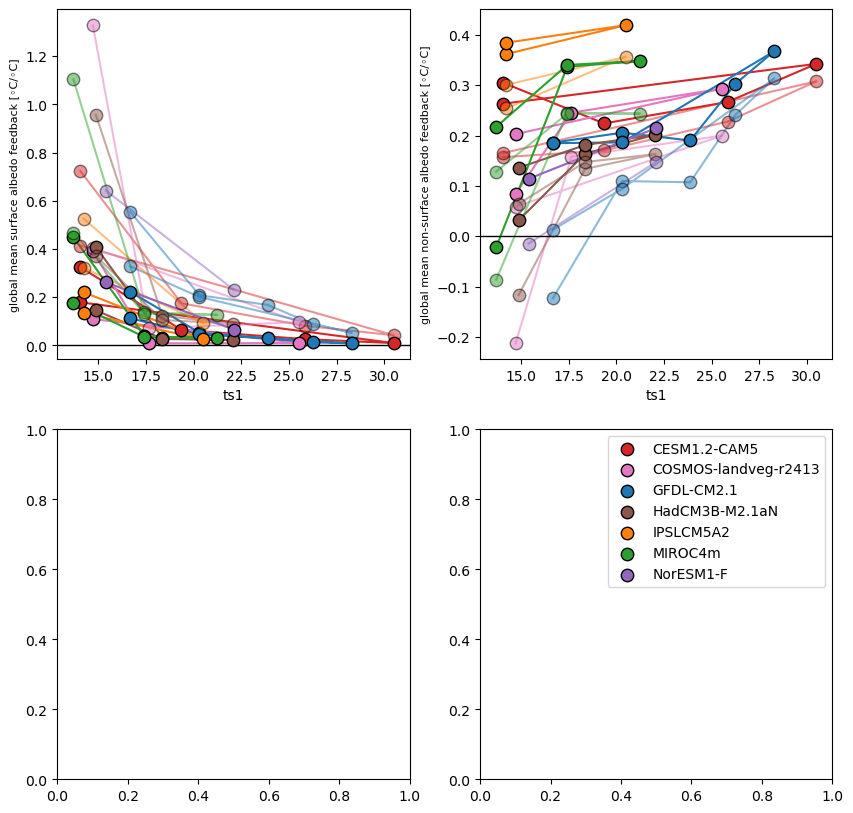

In [4]:
# create scatter plots of globale/regional EBM/APRP comparison
fig, ax = plt.subplots(2,2, figsize=(10, 10))

# Loop through the models and scenarios to plot the scatter points
for model, scenarios in GLO_means.items():
    x_values = []

    # GM surface albedo
    y_values_EBM = []
    y_values_APRP = []
    # EBM results
    for scenario, values in scenarios.items():
        x_value = values['ts1'] - 273.15
        x_values.append(x_value)

        # EBM results
        y_value_EBM = values['dt_salb'] / ( values['ts2'] - values['ts1'] )
        y_values_EBM.append(y_value_EBM)
        ax[0,0].scatter(x_value, 
            y_value_EBM, 
            color=deepmip_dict[model]['pcolor'], 
            label=model, 
            alpha=0.5, 
            edgecolors='black',
            s=80)
        
        # APRP results
        y_value_APRP = values['dt_aprp_alf'] / ( values['ts2'] - values['ts1'] )
        y_values_APRP.append(y_value_APRP)
        ax[0,0].scatter(x_value, 
            y_value_APRP, 
            color=deepmip_dict[model]['pcolor'], 
            label=model, 
            alpha=1.0, 
            edgecolors='black',
            s=80)
        
    # After collecting all points for the model, plot lines connecting them
    ax[0,0].plot(x_values, y_values_EBM, color=deepmip_dict[model]['pcolor'], alpha=0.5, zorder=0)
    ax[0,0].plot(x_values, y_values_APRP, color=deepmip_dict[model]['pcolor'], alpha=1.0, zorder=0)

    x_values = []

    # gm clouds albedo
    y_values_EBM = []
    y_values_APRP = []
    # EBM results
    for scenario, values in scenarios.items():
        x_value = values['ts1'] - 273.15
        x_values.append(x_value)

        # EBM results
        y_value_EBM = values['dt_swcre'] / ( values['ts2'] - values['ts1'] )
        y_values_EBM.append(y_value_EBM)
        ax[0,1].scatter(x_value, 
            y_value_EBM, 
            color=deepmip_dict[model]['pcolor'], 
            label=model, 
            alpha=0.5, 
            edgecolors='black',
            s=80)
        
        # APRP results
        y_value_APRP = (values['dt_aprp_cld'] + values['dt_aprp_clr']) / ( values['ts2'] - values['ts1'] )
        y_values_APRP.append(y_value_APRP)
        ax[0,1].scatter(x_value, 
            y_value_APRP, 
            color=deepmip_dict[model]['pcolor'], 
            label=model, 
            alpha=1.0, 
            edgecolors='black',
            s=80)
        
    # After collecting all points for the model, plot lines connecting them
    ax[0,1].plot(x_values, y_values_EBM, color=deepmip_dict[model]['pcolor'], alpha=0.5, zorder=0)
    ax[0,1].plot(x_values, y_values_APRP, color=deepmip_dict[model]['pcolor'], alpha=1.0, zorder=0)

        
# Adding legend, you might want to handle duplicates
handles, labels = ax[0,0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

ax[0,0].set_xlabel('ts1')
ax[0,0].set_ylabel('global mean surface albedo feedback [◦C/◦C]',fontsize=8)
ax[0,0].axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)

ax[0,1].set_xlabel('ts1')
ax[0,1].set_ylabel('global mean non-surface albedo feedback [◦C/◦C]',fontsize=8)
ax[0,1].axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)

plt.show()

sensemble means: [array(1.85238218), array(3.27451361), -1.4221314248584567, array(1.62899256), 1.69529653207532, array(-0.06630397), array(0.03238132), array(3.63549223)]
sensemble means: [array(4.33409818), array(13.6841512), -9.35005301520938, array(4.44707605), 2.908115157946235, array(1.53896089), array(-1.33157566), array(7.92108445)]
sensemble means: [array(1.80165893), array(0.8707876), 0.9308713277180989, array(4.68069858), 4.93816970643543, array(-0.25747113), array(0.04347841), array(6.58894275)]
sensemble means: [array(-0.41030383), array(4.76640407), -5.176707902391042, array(1.88431113), 0.408366356577192, array(1.47594477), array(2.04303757), array(4.02457101)]
sensemble means: [array(4.11886955), array(4.11065195), 0.00821759749431994, array(6.28469732), 6.785915719003094, array(-0.5012184), array(0.04295482), array(10.6731804)]
sensemble means: [array(4.44126736), array(18.04297691), -13.601709550740768, array(5.97159366), 3.2140430917545246, array(2.75755057), array(0

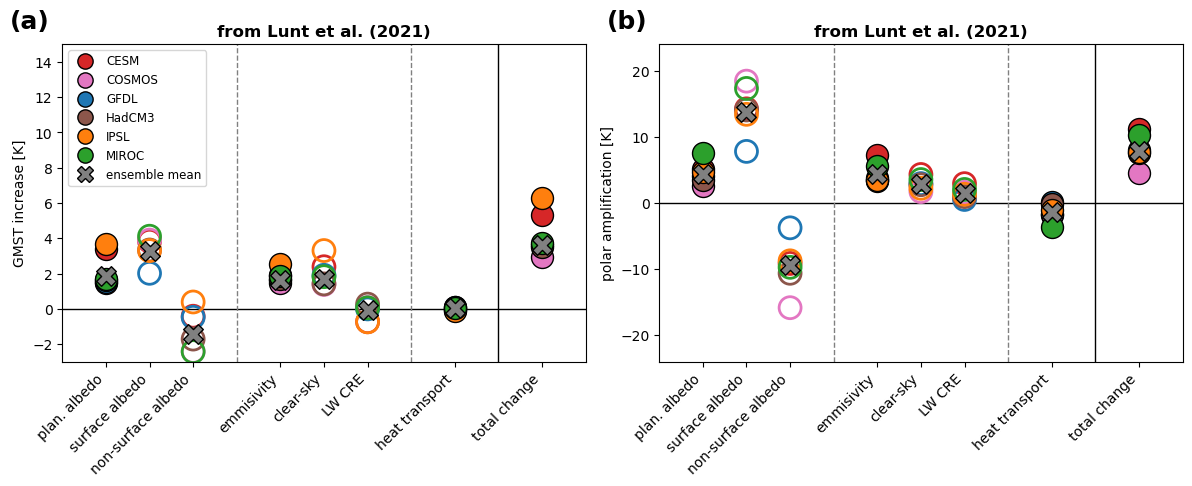

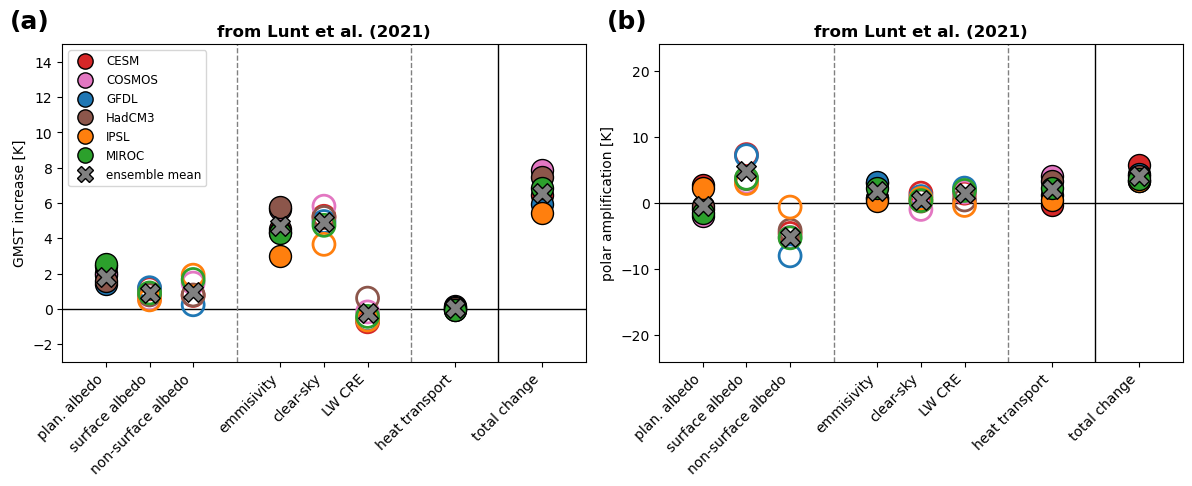

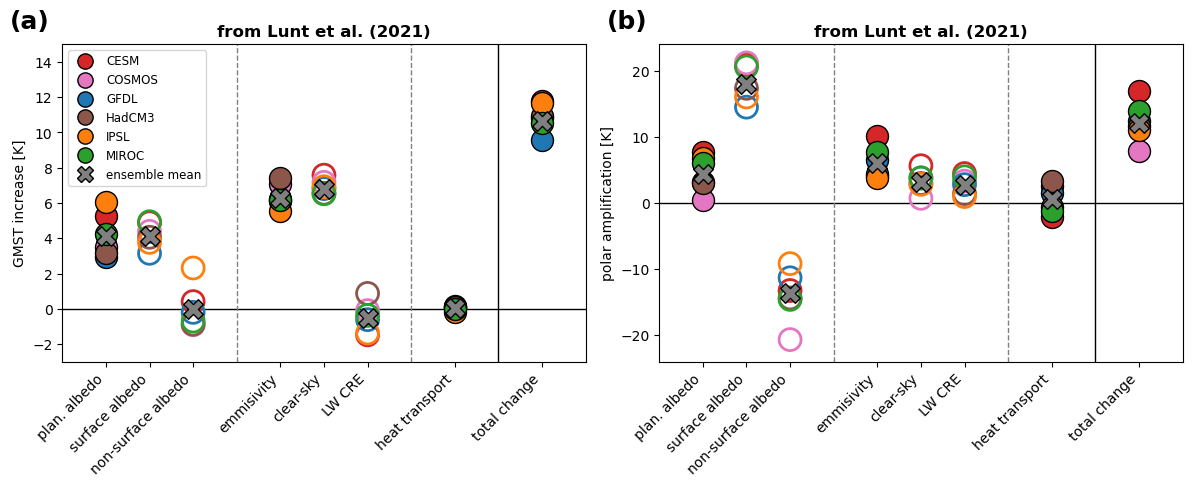

In [106]:
import matplotlib.pyplot as plt

scenario_list = ['deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x1', 'deepmip-eocene-p1-x1_to_deepmip-eocene-p1-x3', 'deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x3']

categories = ['plan. albedo', 'surface albedo', 'SW CRE', 'emmisivity', 'clear-sky', 'LW CRE', 'heat transport', 'total change']
categories = ['plan. albedo', 'surface albedo', 'non-surface albedo', 'emmisivity', 'clear-sky', 'LW CRE', 'heat transport', 'total change']

x_positions = [0, 1, 2, 4, 5, 6, 8, 10]

marker_size = 250

for target_scenario in scenario_list:
    # Create scatter plots of global/regional EBM/APRP comparison
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Loop through the models and scenarios to plot the scatter points
    for model, scenarios in GLO_means.items():
        if model == 'ensemble-mean':
            continue
        for scenario, values in scenarios.items():
            if scenario == target_scenario or ( target_scenario == 'deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x1' and scenario == 'deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x1.5' ) or ( target_scenario == 'deepmip-eocene-p1-x1_to_deepmip-eocene-p1-x3' and scenario == 'deepmip-eocene-p1-x1.5_to_deepmip-eocene-p1-x3' ):
                row = 0

                # global means
                y_values_gm = [
                    values['dt_palb'].values,
                    # values['dt_palb'].values - values['dt_swcre'].values,
                    # values['dt_swcre'].values,
                    values['dt_salb'].values,
                    values['dt_palb'].values - values['dt_salb'].values,
                    values['dt_emm'].values,
                    values['dt_emm'].values - values['dt_lwcre'].values,
                    values['dt_lwcre'].values,
                    values['dt_htc'].values,
                    (values['ts2'] - values['ts1']).values
                ]

                # MTG 
                y_values_amp = [
                    AMP_means[model][scenario]['dt_palb'].values,
                    # AMP_means[model][scenario]['dt_palb'].values - AMP_means[model][scenario]['dt_swcre'].values,
                    # AMP_means[model][scenario]['dt_swcre'].values,
                    AMP_means[model][scenario]['dt_salb'].values,
                    AMP_means[model][scenario]['dt_palb'].values - AMP_means[model][scenario]['dt_salb'].values,
                    AMP_means[model][scenario]['dt_emm'].values,
                    AMP_means[model][scenario]['dt_emm'].values - AMP_means[model][scenario]['dt_lwcre'].values,
                    AMP_means[model][scenario]['dt_lwcre'].values,
                    AMP_means[model][scenario]['dt_htc'].values,
                    (AMP_means[model][scenario]['ts2'] - AMP_means[model][scenario]['ts1']).values
                ]

                facecolors = [
                    deepmip_dict[model]['pcolor'], 'none', 'none', deepmip_dict[model]['pcolor'], 'none', 'none', deepmip_dict[model]['pcolor'], deepmip_dict[model]['pcolor']
                ]

                for i, (x_pos, y_val_gm, y_val_amp, facecolor) in enumerate(zip(x_positions, y_values_gm, y_values_amp, facecolors)):
                    if facecolor == 'none':
                        edgecolor = deepmip_dict[model]['pcolor']
                        edgewidth = 2.0
                    else:
                        edgecolor = 'black'
                        edgewidth = 1.0
                    ax[0].scatter(
                        x_pos,
                        y_val_gm,
                        facecolor=facecolor,  # Set the facecolor for each point
                        label=deepmip_dict[model]['group'] if i == 0 else "",
                        alpha=1.0,
                        edgecolors=edgecolor,
                        marker='o',
                        linewidth=edgewidth, 
                        s=marker_size
                    )

                    ax[1].scatter(
                        x_pos,
                        y_val_amp,
                        facecolor=facecolor,  # Set the facecolor for each point
                        label=deepmip_dict[model]['group'] if i == 0 else "",
                        alpha=1.0,
                        edgecolors=edgecolor,
                        marker='o',
                        linewidth=edgewidth, 
                        s=marker_size
                    )

    # add ensemble mean markers
    ensemble_model = 'ensemble-mean'
    if ensemble_model in GLO_means and target_scenario in GLO_means[ensemble_model]:
        ensemble_gm = [
            GLO_means[ensemble_model][target_scenario]['dt_palb'].values,
            GLO_means[ensemble_model][target_scenario]['dt_salb'].values,
            GLO_means[ensemble_model][target_scenario]['dt_palb'].values - GLO_means[ensemble_model][target_scenario]['dt_salb'].values,
            GLO_means[ensemble_model][target_scenario]['dt_emm'].values,
            GLO_means[ensemble_model][target_scenario]['dt_emm'].values - GLO_means[ensemble_model][target_scenario]['dt_lwcre'].values,
            GLO_means[ensemble_model][target_scenario]['dt_lwcre'].values,
            GLO_means[ensemble_model][target_scenario]['dt_htc'].values,
            (GLO_means[ensemble_model][target_scenario]['ts2'] - GLO_means[ensemble_model][target_scenario]['ts1']).values
        ]

        ensemble_amp = [
            AMP_means[ensemble_model][target_scenario]['dt_palb'].values,
            AMP_means[ensemble_model][target_scenario]['dt_salb'].values,
            AMP_means[ensemble_model][target_scenario]['dt_palb'].values - AMP_means[ensemble_model][target_scenario]['dt_salb'].values,
            AMP_means[ensemble_model][target_scenario]['dt_emm'].values,
            AMP_means[ensemble_model][target_scenario]['dt_emm'].values - AMP_means[ensemble_model][target_scenario]['dt_lwcre'].values,
            AMP_means[ensemble_model][target_scenario]['dt_lwcre'].values,
            AMP_means[ensemble_model][target_scenario]['dt_htc'].values,
            (AMP_means[ensemble_model][target_scenario]['ts2'] - AMP_means[ensemble_model][target_scenario]['ts1']).values
        ]

        print("sensemble means:", ensemble_gm)
        print("sensemble means:", ensemble_amp)

        for i, (x_pos, y_val_gm, y_val_amp, facecolor) in enumerate(zip(x_positions, ensemble_gm, ensemble_amp, facecolors)):
            if facecolor == 'none':
                # edgecolor = "gray"
                # edgewidth = 3.0
                # color = 'none'
                edgecolor = 'black'
                edgewidth = 1.0
                color = 'gray'
            else:
                edgecolor = 'black'
                edgewidth = 1.0
                color = 'gray'
            ax[0].scatter(
                x_pos,
                y_val_gm,
                facecolor=color,  # Ensemble mean marker color
                edgecolors=edgecolor,
                marker='X',
                linewidth=edgewidth, 
                s=200,
                alpha=1.0,
                label=None
            )

            ax[1].scatter(
                x_pos,
                y_val_amp,
                facecolor=color,  # Ensemble mean marker color
                edgecolors=edgecolor,
                marker='X',
                linewidth=edgewidth, 
                s=200,
                alpha=1.0,
                label=None
            )


    titles = ['GMST increase [K]', 'polar amplification [K]']

    # Set custom x-ticks and labels
    for col in range(2):
        ax[col].set_xticks(x_positions)
        ax[col].set_xticklabels(categories, rotation=45, ha='right')
        # ax[col].set_xticklabels(categories, rotation=90, ha='center')
        ax[col].set_ylabel(titles[col])
        ax[col].axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)
        ax[col].axvline(x=x_positions[2] + 1.0, color='gray', linestyle='--', linewidth=1)
        ax[col].axvline(x=x_positions[5] + 1.0, color='gray', linestyle='--', linewidth=1)
        ax[col].axvline(x=x_positions[6] + 1.0, color='black', linestyle='-', linewidth=1)
        ax[col].set_title('from Lunt et al. (2021)', fontweight='bold')

        ax[col].set_xlim(-1.0, max(x_positions) + 1.0)

    ax[0].set_ylim(-3, 15)
    ax[1].set_ylim(-24, 24)

    # Adjust legend markers size
    handles, labels = ax[0].get_legend_handles_labels()

    # Create a small legend for the models
    small_legend = [plt.Line2D([0], [0], marker='o', color='w', markeredgecolor='black', 
                            markerfacecolor=deepmip_dict[model]['pcolor'], markersize=11., markeredgewidth=1.0)
                    for model in GLO_means.keys() if model in deepmip_dict and model != 'NorESM1-F']

    # Manually add the ensemble-mean entry
    ensemble_legend = plt.Line2D([0], [0], marker='X', color='w', markeredgecolor='black', 
                                markerfacecolor='gray', markersize=11., markeredgewidth=1.0)
    small_legend.append(ensemble_legend)
    labels.append('ensemble mean')

    ax[0].legend(small_legend, labels, loc='upper left', fontsize=8.5)

    add_panel_labels(ax, fontsize=18, x_offset=-0.1, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f"{figure_dir}/EBM_main_conmponents_scatter_{target_scenario}.pdf")  # Save each model's plots as a PDF
# plt.close()

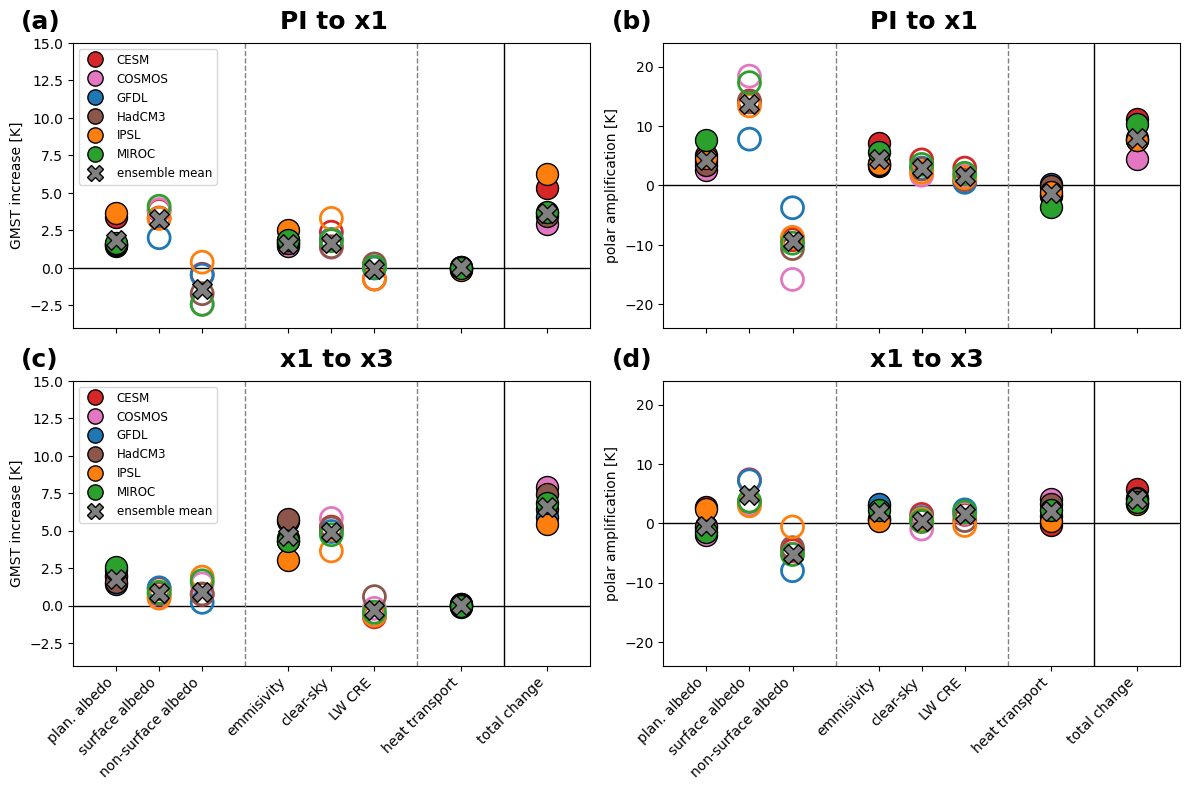

In [102]:
import matplotlib.pyplot as plt

scenario_list = ['deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x1', 'deepmip-eocene-p1-x1_to_deepmip-eocene-p1-x3']

categories = ['plan. albedo', 'surface albedo', 'SW CRE', 'emmisivity', 'clear-sky', 'LW CRE', 'heat transport', 'total change']
categories = ['plan. albedo', 'surface albedo', 'non-surface albedo', 'emmisivity', 'clear-sky', 'LW CRE', 'heat transport', 'total change']

x_positions = [0, 1, 2, 4, 5, 6, 8, 10]

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

for row,target_scenario in enumerate(scenario_list):
    # Create scatter plots of global/regional EBM/APRP comparison

    # Loop through the models and scenarios to plot the scatter points
    for model, scenarios in GLO_means.items():
        if model == 'ensemble-mean':
            continue
        for scenario, values in scenarios.items():
            if scenario == target_scenario or ( target_scenario == 'deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x1' and scenario == 'deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x1.5' ) or ( target_scenario == 'deepmip-eocene-p1-x1_to_deepmip-eocene-p1-x3' and scenario == 'deepmip-eocene-p1-x1.5_to_deepmip-eocene-p1-x3' ):

                # global means
                y_values_gm = [
                    values['dt_palb'].values,
                    # values['dt_palb'].values - values['dt_swcre'].values,
                    # values['dt_swcre'].values,
                    values['dt_salb'].values,
                    values['dt_palb'].values - values['dt_salb'].values,
                    values['dt_emm'].values,
                    values['dt_emm'].values - values['dt_lwcre'].values,
                    values['dt_lwcre'].values,
                    values['dt_htc'].values,
                    (values['ts2'] - values['ts1']).values
                ]

                # MTG 
                y_values_amp = [
                    AMP_means[model][scenario]['dt_palb'].values,
                    # AMP_means[model][scenario]['dt_palb'].values - AMP_means[model][scenario]['dt_swcre'].values,
                    # AMP_means[model][scenario]['dt_swcre'].values,
                    AMP_means[model][scenario]['dt_salb'].values,
                    AMP_means[model][scenario]['dt_palb'].values - AMP_means[model][scenario]['dt_salb'].values,
                    AMP_means[model][scenario]['dt_emm'].values,
                    AMP_means[model][scenario]['dt_emm'].values - AMP_means[model][scenario]['dt_lwcre'].values,
                    AMP_means[model][scenario]['dt_lwcre'].values,
                    AMP_means[model][scenario]['dt_htc'].values,
                    (AMP_means[model][scenario]['ts2'] - AMP_means[model][scenario]['ts1']).values
                ]

                facecolors = [
                    deepmip_dict[model]['pcolor'], 'none', 'none', deepmip_dict[model]['pcolor'], 'none', 'none', deepmip_dict[model]['pcolor'], deepmip_dict[model]['pcolor']
                ]

                for i, (x_pos, y_val_gm, y_val_amp, facecolor) in enumerate(zip(x_positions, y_values_gm, y_values_amp, facecolors)):
                    if facecolor == 'none':
                        edgecolor = deepmip_dict[model]['pcolor']
                        edgewidth = 2.0
                    else:
                        edgecolor = 'black'
                        edgewidth = 1.0
                    ax[row,0].scatter(
                        x_pos,
                        y_val_gm,
                        facecolor=facecolor,  # Set the facecolor for each point
                        label=deepmip_dict[model]['group'] if i == 0 else "",
                        alpha=1.0,
                        edgecolors=edgecolor,
                        marker='o',
                        linewidth=edgewidth, 
                        s=marker_size
                    )

                    ax[row,1].scatter(
                        x_pos,
                        y_val_amp,
                        facecolor=facecolor,  # Set the facecolor for each point
                        label=deepmip_dict[model]['group'] if i == 0 else "",
                        alpha=1.0,
                        edgecolors=edgecolor,
                        marker='o',
                        linewidth=edgewidth, 
                        s=marker_size
                    )
                    
    # add ensemble mean markers
    ensemble_model = 'ensemble-mean'
    if ensemble_model in GLO_means and target_scenario in GLO_means[ensemble_model]:
        ensemble_gm = [
            GLO_means[ensemble_model][target_scenario]['dt_palb'].values,
            GLO_means[ensemble_model][target_scenario]['dt_salb'].values,
            GLO_means[ensemble_model][target_scenario]['dt_palb'].values - GLO_means[ensemble_model][target_scenario]['dt_salb'].values,
            GLO_means[ensemble_model][target_scenario]['dt_emm'].values,
            GLO_means[ensemble_model][target_scenario]['dt_emm'].values - GLO_means[ensemble_model][target_scenario]['dt_lwcre'].values,
            GLO_means[ensemble_model][target_scenario]['dt_lwcre'].values,
            GLO_means[ensemble_model][target_scenario]['dt_htc'].values,
            (GLO_means[ensemble_model][target_scenario]['ts2'] - GLO_means[ensemble_model][target_scenario]['ts1']).values
        ]

        ensemble_amp = [
            AMP_means[ensemble_model][target_scenario]['dt_palb'].values,
            AMP_means[ensemble_model][target_scenario]['dt_salb'].values,
            AMP_means[ensemble_model][target_scenario]['dt_palb'].values - AMP_means[ensemble_model][target_scenario]['dt_salb'].values,
            AMP_means[ensemble_model][target_scenario]['dt_emm'].values,
            AMP_means[ensemble_model][target_scenario]['dt_emm'].values - AMP_means[ensemble_model][target_scenario]['dt_lwcre'].values,
            AMP_means[ensemble_model][target_scenario]['dt_lwcre'].values,
            AMP_means[ensemble_model][target_scenario]['dt_htc'].values,
            (AMP_means[ensemble_model][target_scenario]['ts2'] - AMP_means[ensemble_model][target_scenario]['ts1']).values
        ]

        for i, (x_pos, y_val_gm, y_val_amp, facecolor) in enumerate(zip(x_positions, ensemble_gm, ensemble_amp, facecolors)):
            if facecolor == 'none':
                # edgecolor = "gray"
                # edgewidth = 3.0
                # color = 'none'
                edgecolor = 'black'
                edgewidth = 1.0
                color = 'gray'
            else:
                edgecolor = 'black'
                edgewidth = 1.0
                color = 'gray'
            ax[row,0].scatter(
                x_pos,
                y_val_gm,
                facecolor=color,  # Ensemble mean marker color
                edgecolors=edgecolor,
                marker='X',
                linewidth=edgewidth, 
                s=200,
                alpha=1.0,
                label=None
            )

            ax[row,1].scatter(
                x_pos,
                y_val_amp,
                facecolor=color,  # Ensemble mean marker color
                edgecolors=edgecolor,
                marker='X',
                linewidth=edgewidth, 
                s=200,
                alpha=1.0,
                label=None
            )

    titles = ['GMST increase [K]', 'polar amplification [K]']

    # Set custom x-ticks and labels
    for col in range(2):
        ax[row,col].set_xticks(x_positions)
        ax[row,col].set_xticklabels(categories, rotation=45, ha='right')
        ax[row,col].set_ylabel(titles[col])
        ax[row,col].axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)
        ax[row,col].axvline(x=x_positions[2] + 1.0, color='gray', linestyle='--', linewidth=1)
        ax[row,col].axvline(x=x_positions[5] + 1.0, color='gray', linestyle='--', linewidth=1)
        ax[row,col].axvline(x=x_positions[6] + 1.0, color='black', linestyle='-', linewidth=1)

        ax[row,col].set_xlim(-1.0, max(x_positions) + 1.0)

    ax[row,0].set_ylim(-4, 15)
    ax[row,1].set_ylim(-24, 24)

    # Adjust legend markers size
    handles, labels = ax[row,0].get_legend_handles_labels()
    
    # Adjust legend markers size
    small_legend = [plt.Line2D([0], [0], marker='o', color='w', markeredgecolor='black', 
                            markerfacecolor=deepmip_dict[model]['pcolor'], markersize=11., markeredgewidth=1.0)
                    for model in GLO_means.keys() if model in deepmip_dict and model != 'NorESM1-F']

    # Manually add the ensemble-mean entry
    ensemble_legend = plt.Line2D([0], [0], marker='X', color='w', markeredgecolor='black', 
                                markerfacecolor='gray', markersize=11., markeredgewidth=1.0)
    small_legend.append(ensemble_legend)
    labels.append('ensemble mean')

    ax[row,0].legend(small_legend, labels, loc='upper left', fontsize=8.5)

add_panel_labels(ax.flatten(), fontsize=18, x_offset=-0.1, y_offset=1.05, fontweight='bold')

ax[0,0].text( 0.4, 1.05, 'PI to x1', fontsize=18, transform=ax[0,0].transAxes, fontweight='bold')
ax[0,1].text( 0.4, 1.05, 'PI to x1', fontsize=18, transform=ax[0,1].transAxes, fontweight='bold')
ax[1,0].text( 0.4, 1.05, 'x1 to x3', fontsize=18, transform=ax[1,0].transAxes, fontweight='bold')
ax[1,1].text( 0.4, 1.05, 'x1 to x3', fontsize=18, transform=ax[1,1].transAxes, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{figure_dir}/EBM_main_conmponents_scatter_SI.pdf")  # Save each model's plots as a PDF
# plt.close()

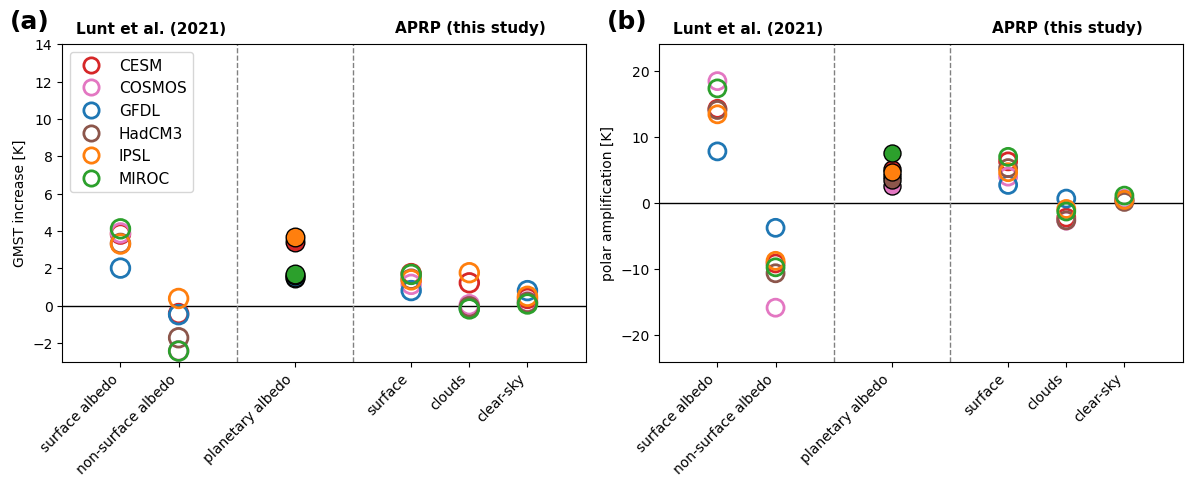

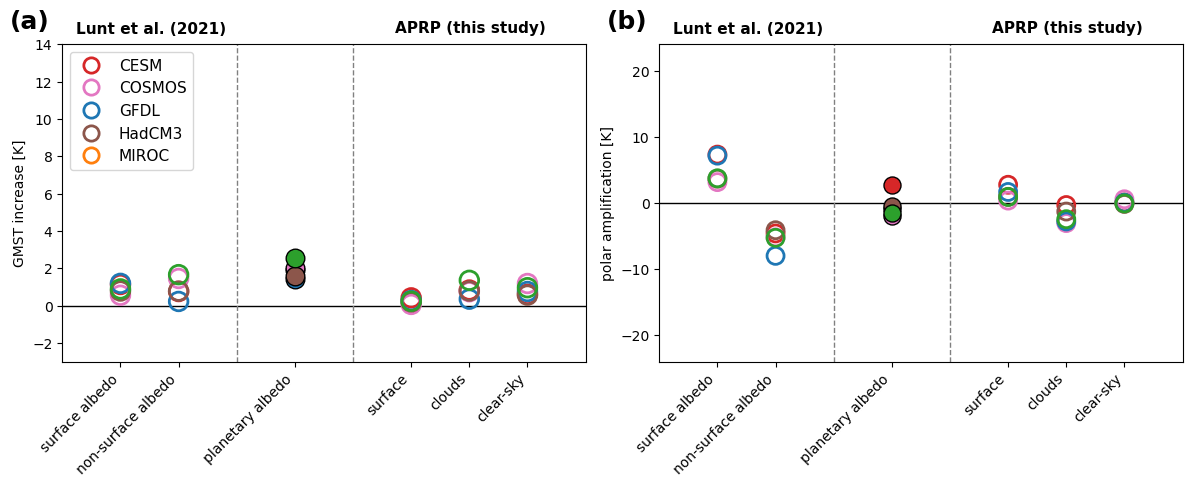

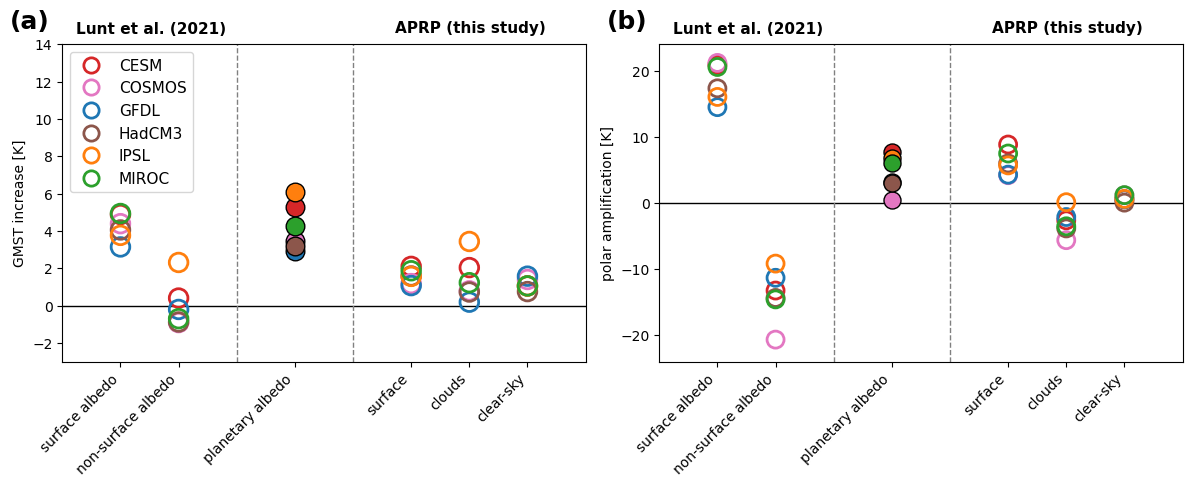

In [162]:
# repeat the scatter plot but showing the APRP results
scenario_list = ['deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x1', 'deepmip-eocene-p1-x1_to_deepmip-eocene-p1-x3', 'deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x3']

categories = [ 'surface albedo', 'non-surface albedo', 'planetary albedo', 'surface', 'clouds', 'clear-sky']

x_positions = [0, 1, 3, 5, 6, 7]

for target_scenario in scenario_list:
    # Create scatter plots of global/regional EBM/APRP comparison
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Loop through the models and scenarios to plot the scatter points
    for model, scenarios in GLO_means.items():
        for scenario, values in scenarios.items():
            if scenario == target_scenario or ( target_scenario == 'deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x1' and scenario == 'deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x1.5' ):
                row = 0

                # global means
                y_values_gm = [
                    # values['dt_palb'].values - values['dt_swcre'].values,
                    # values['dt_swcre'].values,
                    values['dt_salb'].values,
                    values['dt_palb'].values - values['dt_salb'].values,
                    values['dt_palb'].values,
                    values['dt_aprp_alf'].values,
                    values['dt_aprp_cld'].values,
                    values['dt_aprp_clr'].values,
                ]

                # MTG 
                y_values_amp = [
                    # AMP_means[model][scenario]['dt_palb'].values - AMP_means[model][scenario]['dt_swcre'].values,
                    # AMP_means[model][scenario]['dt_swcre'].values,
                    AMP_means[model][scenario]['dt_salb'].values,
                    AMP_means[model][scenario]['dt_palb'].values - AMP_means[model][scenario]['dt_salb'].values,
                    AMP_means[model][scenario]['dt_palb'].values,
                    AMP_means[model][scenario]['dt_aprp_alf'].values,
                    AMP_means[model][scenario]['dt_aprp_cld'].values,
                    AMP_means[model][scenario]['dt_aprp_clr'].values,
                ]

                facecolors = [
                     'none', 'none', deepmip_dict[model]['pcolor'], 'none', 'none', 'none'
                ]

                for i, (x_pos, y_val_gm, y_val_amp, facecolor) in enumerate(zip(x_positions, y_values_gm, y_values_amp, facecolors)):
                    if facecolor == 'none':
                        edgecolor = deepmip_dict[model]['pcolor']
                        edgewidth = 2.0
                        alpha = 1.0
                    else:
                        edgecolor = 'black'
                        edgewidth = 1.0
                        alpha = 1.0
                    ax[0].scatter(
                        x_pos,
                        y_val_gm,
                        facecolor=facecolor,  # Set the facecolor for each point
                        label=deepmip_dict[model]['group'] if i == 0 else "",
                        alpha=alpha,
                        edgecolors=edgecolor,
                        marker='o',
                        linewidth=edgewidth, 
                        s=180
                    )

                    ax[1].scatter(
                        x_pos,
                        y_val_amp,
                        facecolor=facecolor,  # Set the facecolor for each point
                        label=deepmip_dict[model]['group'] if i == 0 else "",
                        alpha=alpha,
                        edgecolors=edgecolor,
                        marker='o',
                        linewidth=edgewidth, 
                        s=150
                    )
                    
    titles = ['GMST increase [K]', 'polar amplification [K]']

    # Set custom x-ticks and labels
    for col in range(2):
        ax[col].set_xticks(x_positions)
        ax[col].set_xticklabels(categories, rotation=45, ha='right')
        ax[col].set_ylabel(titles[col])
        ax[col].axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)
        ax[col].axvline(x=x_positions[1] + 1.0, color='gray', linestyle='--', linewidth=1)
        ax[col].axvline(x=x_positions[2] + 1.0, color='gray', linestyle='--', linewidth=1)
        ax[col].set_xlim(-1.0, max(x_positions) + 1.0)
        ax[col].text(0.17, 1.05, 'Lunt et al. (2021)', horizontalalignment='center', verticalalignment='center', transform=ax[col].transAxes, fontsize=11, fontweight='bold')
        ax[col].text(0.78, 1.05, 'APRP (this study)', horizontalalignment='center', verticalalignment='center', transform=ax[col].transAxes, fontsize=11, fontweight='bold')

    ax[0].set_ylim(-3, 14)
    ax[1].set_ylim(-24, 24)



    # Adjust legend markers size
    handles, labels = ax[0].get_legend_handles_labels()
    small_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
                            markeredgecolor=deepmip_dict[model]['pcolor'], markersize=11, markeredgewidth=2.0)
                    for model in GLO_means.keys()]
    ax[0].legend(small_legend, labels, loc='upper left', fontsize=11)

    add_panel_labels(ax, fontsize=18, x_offset=-0.1, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{figure_dir}/EBM_vs_APRP_main_conmponents_scatter_{target_scenario}.pdf")  # Save each model's plots as a PDF
# plt.close()

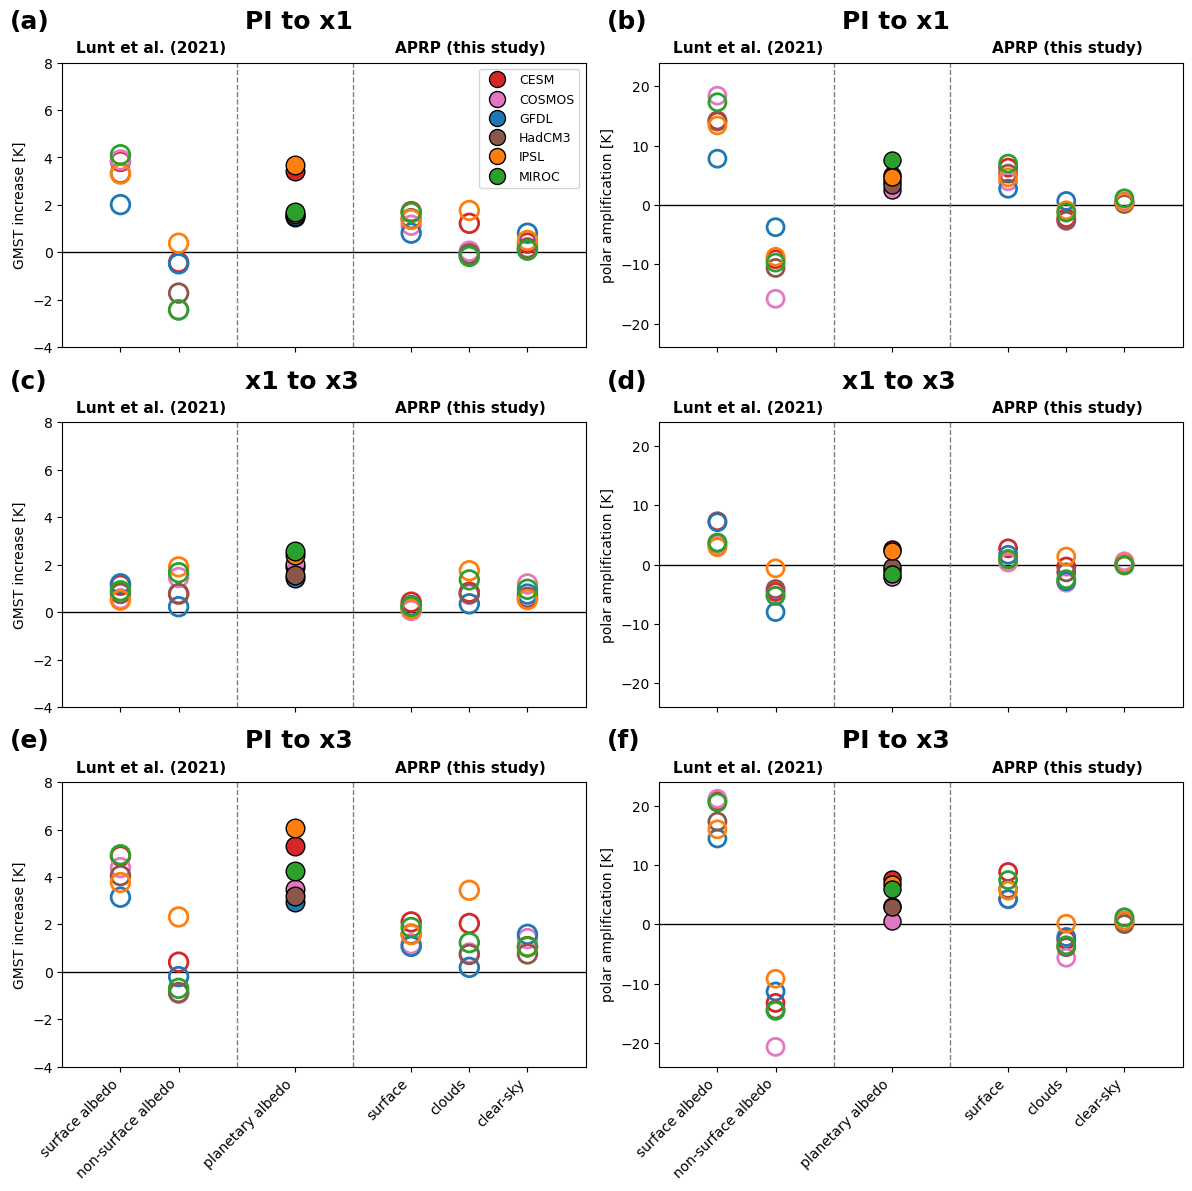

In [166]:
import matplotlib.pyplot as plt

scenario_list = ['deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x1', 'deepmip-eocene-p1-x1_to_deepmip-eocene-p1-x3', 'deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x3']

categories = [ 'surface albedo', 'non-surface albedo', 'planetary albedo', 'surface', 'clouds', 'clear-sky']

x_positions = [0, 1, 3, 5, 6, 7]

fig, ax = plt.subplots(3, 2, figsize=(12, 12), sharex=True)

for row,target_scenario in enumerate(scenario_list):
    # Create scatter plots of global/regional EBM/APRP comparison

    # Loop through the models and scenarios to plot the scatter points
    for model, scenarios in GLO_means.items():
        for scenario, values in scenarios.items():
            if scenario == target_scenario or ( target_scenario == 'deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x1' and scenario == 'deepmip-eocene-p1-PI_to_deepmip-eocene-p1-x1.5' ) or ( target_scenario == 'deepmip-eocene-p1-x1_to_deepmip-eocene-p1-x3' and scenario == 'deepmip-eocene-p1-x1.5_to_deepmip-eocene-p1-x3' ):

                # global means
                y_values_gm = [
                    # values['dt_palb'].values - values['dt_swcre'].values,
                    # values['dt_swcre'].values,
                    values['dt_salb'].values,
                    values['dt_palb'].values - values['dt_salb'].values,
                    values['dt_palb'].values,
                    values['dt_aprp_alf'].values,
                    values['dt_aprp_cld'].values,
                    values['dt_aprp_clr'].values,
                ]

                # MTG 
                y_values_amp = [
                    # AMP_means[model][scenario]['dt_palb'].values - AMP_means[model][scenario]['dt_swcre'].values,
                    # AMP_means[model][scenario]['dt_swcre'].values,
                    AMP_means[model][scenario]['dt_salb'].values,
                    AMP_means[model][scenario]['dt_palb'].values - AMP_means[model][scenario]['dt_salb'].values,
                    AMP_means[model][scenario]['dt_palb'].values,
                    AMP_means[model][scenario]['dt_aprp_alf'].values,
                    AMP_means[model][scenario]['dt_aprp_cld'].values,
                    AMP_means[model][scenario]['dt_aprp_clr'].values,
                ]

                facecolors = [
                     'none', 'none', deepmip_dict[model]['pcolor'], 'none', 'none', 'none'
                ]

                for i, (x_pos, y_val_gm, y_val_amp, facecolor) in enumerate(zip(x_positions, y_values_gm, y_values_amp, facecolors)):
                    if facecolor == 'none':
                        edgecolor = deepmip_dict[model]['pcolor']
                        edgewidth = 2.0
                        alpha = 1.0
                    else:
                        edgecolor = 'black'
                        edgewidth = 1.0
                        alpha = 1.0
                    ax[row, 0].scatter(
                        x_pos,
                        y_val_gm,
                        facecolor=facecolor,  # Set the facecolor for each point
                        label=deepmip_dict[model]['group'] if i == 0 else "",
                        alpha=alpha,
                        edgecolors=edgecolor,
                        marker='o',
                        linewidth=edgewidth, 
                        s=180
                    )

                    ax[row, 1].scatter(
                        x_pos,
                        y_val_amp,
                        facecolor=facecolor,  # Set the facecolor for each point
                        label=deepmip_dict[model]['group'] if i == 0 else "",
                        alpha=alpha,
                        edgecolors=edgecolor,
                        marker='o',
                        linewidth=edgewidth, 
                        s=150
                    )
                    
    titles = ['GMST increase [K]', 'polar amplification [K]']

    # Set custom x-ticks and labels
    for col in range(2):
        ax[row,col].set_xticks(x_positions)
        ax[row,col].set_xticklabels(categories, rotation=45, ha='right')
        ax[row,col].set_ylabel(titles[col])
        ax[row,col].axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)
        ax[row,col].axvline(x=x_positions[1] + 1.0, color='gray', linestyle='--', linewidth=1)
        ax[row,col].axvline(x=x_positions[2] + 1.0, color='gray', linestyle='--', linewidth=1)
        ax[row,col].set_xlim(-1.0, max(x_positions) + 1.0)
        ax[row,col].text(0.17, 1.05, 'Lunt et al. (2021)', horizontalalignment='center', verticalalignment='center', transform=ax[row,col].transAxes, fontsize=11, fontweight='bold')
        ax[row,col].text(0.78, 1.05, 'APRP (this study)', horizontalalignment='center', verticalalignment='center', transform=ax[row,col].transAxes, fontsize=11, fontweight='bold')

    ax[row,0].set_ylim(-4, 8)
    ax[row,1].set_ylim(-24, 24)

    # Adjust legend markers size
    if row == 0:
        handles, labels = ax[row,0].get_legend_handles_labels()
        small_legend = [plt.Line2D([row,0], [row,0], marker='o', color='w', markeredgecolor='black', 
                                markerfacecolor=deepmip_dict[model]['pcolor'], markersize=11.5, markeredgewidth=1.0)
                        for model in GLO_means.keys()]
        ax[row,0].legend(small_legend, labels, loc='best', fontsize=9)

add_panel_labels(ax.flatten(), fontsize=18, x_offset=-0.1, y_offset=1.12, fontweight='bold')

ax[0,0].text( 0.35, 1.12, 'PI to x1', fontsize=18, transform=ax[0,0].transAxes, fontweight='bold')
ax[0,1].text( 0.35, 1.12, 'PI to x1', fontsize=18, transform=ax[0,1].transAxes, fontweight='bold')
ax[1,0].text( 0.35, 1.12, 'x1 to x3', fontsize=18, transform=ax[1,0].transAxes, fontweight='bold')
ax[1,1].text( 0.35, 1.12, 'x1 to x3', fontsize=18, transform=ax[1,1].transAxes, fontweight='bold')
ax[2,0].text( 0.35, 1.12, 'PI to x3', fontsize=18, transform=ax[2,0].transAxes, fontweight='bold')
ax[2,1].text( 0.35, 1.12, 'PI to x3', fontsize=18, transform=ax[2,1].transAxes, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{figure_dir}/EBM_vs_APRP_main_conmponents_scatter_3_rows.pdf")  # Save each model's plots as a PDF
# plt.close()